In [515]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()


In [516]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [517]:
# hyper parameters
# context length: how many previous tokens will be used to predict the next
import random
block_size = 3
emb_dim = 10  # dimension of embedding vector
h_size = 300  # size of hidden layer
epochs = 200000
batch_size = 64


def build_dataset(words):
    ins, outs = [], []

    for w in words:
        # for w in words[:5]:
        # print(w)
        context = [0] * block_size  # init empty context for first word
        for ch in (w+'.'):
            ix = stoi[ch]
            ins.append(context)
            outs.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]  # move forward in context

    ins = torch.tensor(ins)
    outs = torch.tensor(outs)
    print(ins.shape, outs.shape)
    return ins, outs


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

in_train, out_train = build_dataset(words[:n1])
in_val, out_val = build_dataset(words[n1:n2])
in_test, out_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [518]:
# two dimensional embedding for each 27 characters
C = torch.randn((len(itos), emb_dim))
# hidden layer
# 100 neurons in the hidden layer, each with an input of (3 context len * 2-dim vector)
W1 = torch.randn(((block_size*emb_dim), h_size))
b1 = torch.randn(h_size)
# output layer
W2 = torch.randn((h_size, len(itos)))
b2 = torch.randn(len(itos))

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)


17697

In [519]:
# decreasing learning rate
lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre


In [520]:
lri = []
lossi = []
stepi = []

for i in range(epochs):
    # minibatch
    ix = torch.randint(0, in_train.shape[0], (batch_size,))

    # forward pass
    emb = C[in_train[ix]]
    h = torch.tanh(emb.view(-1, (block_size*emb_dim)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, out_train[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())


1.994176983833313


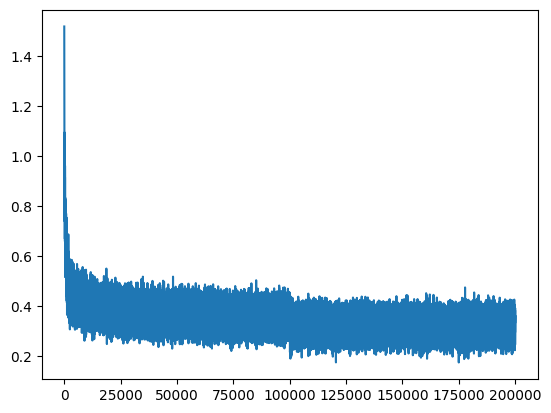

In [521]:
plt.plot(stepi, lossi)


In [522]:
# loss on training dataset
emb = C[in_train]
h = torch.tanh(emb.view(-1, (block_size*emb_dim)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, out_train)
loss.item()


2.1113123893737793

In [523]:
# loss on validation dataset
emb = C[in_val]
h = torch.tanh(emb.view(-1, (block_size*emb_dim)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, out_val)
loss.item()


2.1802868843078613

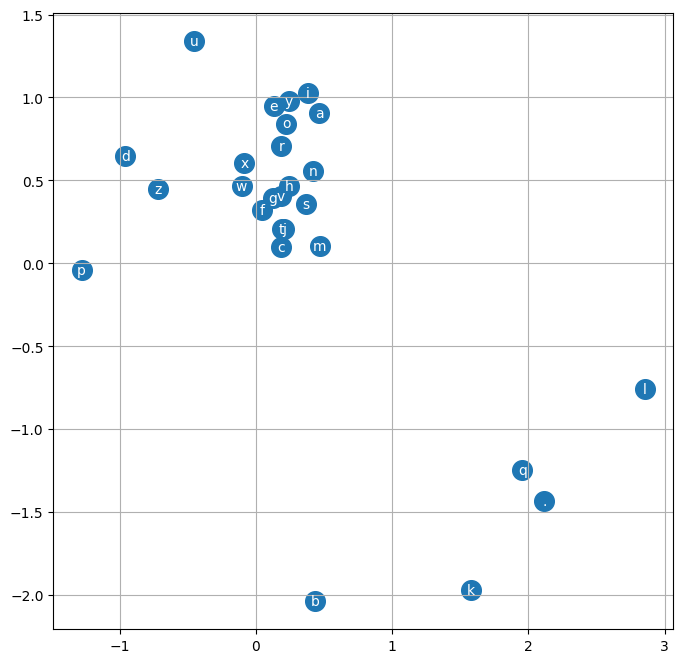

In [524]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color='white')
plt.grid('minor')


In [532]:
# sampling from model
g = torch.Generator().manual_seed(1001+1)
for i in range(20):
    out = []
    s_context = [0] * block_size
    while True:
        s_emb = C[torch.tensor([s_context])]
        s_h = torch.tanh(s_emb.view(1, -1) @ W1 + b1)
        s_logits = s_h @ W2 + b2
        s_probs = F.softmax(s_logits, dim=1)
        s_ix = torch.multinomial(s_probs, num_samples=1, generator=g).item()
        s_context = s_context[1:] + [s_ix]
        out.append(s_ix)
        if s_ix == 0:
            break
    print(''.join(itos[i] for i in out))


beth.
zyani.
demellen.
tyuuberlin.
mohtana.
kalaniola.
samarian.
lela.
zophios.
tae.
baylynn.
mehlyn.
keh.
adean.
kaliyah.
bracy.
uakaison.
maxtyna.
seina.
maa.
